In [1]:
import pandas as pd
import requests
import tasking_manager_client as tm
from datetime import datetime
from IPython.display import HTML, Markdown
from matplotlib.colors import LinearSegmentedColormap
import matplotlib.pyplot as plt
import numpy as np

In [2]:
##### notebook execution parameters & usage #####

TEXT_SEARCH = "" #@param {type:"string"}
CAMPAIGN = "COVID-19" #@param {type:"string"}
projectStatuses = "ARCHIVED,PUBLISHED,DRAFT" #@param {type:"string"}
DEFAULT_INSTANCE = 'tasking-manager-tm4-production-api.hotosm.org' #@param {type:"string"}
ACTIVATION_DATE = datetime(2020,3,25)

# this jupyter notebook is intended to be executed, and then read with
# cell inputs hidden.
# 
# jupyter notebook automated-report-....ipynb --to html --execute --no-prompt --no-input


In [4]:

# notebook utility function definitions

# make sure pandas doesn't truncate the dataframe when rendered
pd.set_option('display.max_rows', 1000)

# colors from the HOTOSM media kit :)
hotosm_colors = {
  "red": "#D73F3F",
  "red-dark": "#6C2020",
  "red-light": "#FFEDED",
  "orange": "#FAA71E",
  "tan": "#F0EFEF",
  "blue-dark": "#2C3038",
  "blue-grey": "#68707F",
  "blue-light": "#929DB3",
  "grey-light": "#E1E0E0",
  "green": "#53AE62"
}


def hotosm_cmap():
    """return a matplotlib red-orange-green colormap using HOTOSM color palette"""
    # create a colormap for colorign mappedness and validatedness percentages
    colors = [
        hotosm_colors['red'], hotosm_colors['orange'],
        hotosm_colors['green']
    ]
    colormap = LinearSegmentedColormap.from_list('hotosm-RdOrGr', colors, N=20)
    return colormap

def format_priority(val: str) -> str:
    """Pandas styler, set cell color based on project priority in TM.
    val: on of LOW, MEDIUM, HIGH, or URGENT"""
    lookup = {
        'LOW': hotosm_colors['grey-light'],
        'MEDIUM': hotosm_colors['green'],
        'HIGH': hotosm_colors['orange'],
        'URGENT': hotosm_colors['red']
    }
    color = lookup.get(val, "none")
    return f'background-color: {color};'


def format_status(val: str) -> str:
    """Pandas styler, set cell color based on proejct status in TM"""
    lookup = {
        'ARCHIVED': hotosm_colors['grey-light'],
        'PUBLISHED': hotosm_colors['green'],
        'DRAFT': hotosm_colors['orange']
    }
    color = lookup.get(val, "none")
    return f'background-color: {color};'


def format_project_link(id: int, instance:str=DEFAULT_INSTANCE) -> str:
    """Returns project URL for given project id.
    Defaults to main TM instance."""
    return f"https://{instance}/project/{id}"


def format_clickable_project_id(id: int, instance:str=DEFAULT_INSTANCE) -> str:
    """Returns a html link tag string linking to the project"""
    url = format_project_link(id, instance=instance)
    return f'<a href="{url}">{id}</a>'


def project_search(textSearch:str="",
                   campaign:str="",
                   mapperLevel:str='ALL',
                   projectStatuses:str='',
                   page:int = 1,
                   token:str='',
                   instance:str=DEFAULT_INSTANCE):
    """Uses GET v2/project/search, generator of search result pages staring from `page`
    projectStatuses: one or both of ARCHIVED, DRAFT, separated by comma"""
 
    # both must be empty, or both must be non-empty
    assert mapperLevel in ['BEGINNER', 'INTERMEDIATE', 'ADVANCED', 'ALL'], "invalid mapper category"

    request_count = 0
    while True:

        r = requests.get(f"https://{instance}/api/v2/projects/",
            params = {
                'textSearch': textSearch,
                'mapperLevel': mapperLevel,
                'projectStatuses': projectStatuses,
                'campaign': campaign,
                'page': page
            },
            headers = {
                'Accept-Language': '*',
                'Content-Type': 'application/json',
                'Authorization': token
            }
        )

        request_count += 1
        assert request_count < 100, "api search query stuck in loop"

        j = r.json()
        assert r.status_code == 200, f"request failed: {j}"

        df = pd.DataFrame(j['results'])
        df['page'] = page

        yield df

        if j['pagination']['hasNext'] is True:
            page = j['pagination']['nextNum']
        else:
            break



# Automated TM project status & statistics report


See the _TM Data aquisition_ section below to check to timestamp of when the data was updated.


In [5]:


# for notebooks used for reporting, it's nice to
# timestamp of the data, since it can get old quickly
now = datetime.utcnow()
print(f'data last updated: {now} UTC')
print(f'tasking manager:   {DEFAULT_INSTANCE}')
print(f'search keyword:    {TEXT_SEARCH}')
print(f'campaign:          {CAMPAIGN}')


# Collect the project data from the API
# concatenate paginated API results into one dataframe

result = pd.concat(
    project_search(textSearch=TEXT_SEARCH,
                   projectStatuses=projectStatuses,
                   campaign=CAMPAIGN
                  ),
    ignore_index=True # each page will have the same set of ids, so they must be ignored
);

# search API pagination sometimes returns the same project more than once (due to pageintaion cacheing)
result = result.drop_duplicates(subset='projectId');

# The country column has the country string wrapped in a 1-length list, convert it to a plain string
result['country'] = result['country'].apply(lambda val: val[0] if isinstance(val, list) else val)

# sort rows to be more reader friendly. Any number of columns can be given in
# the list for hierarchical sorting 

display_result = result.sort_values(by=['country','projectId' ])

# Many of the coulmns are unnecessary for an overview, we select only a few of them
display_result = display_result[['projectId', 'name', 'country', 'percentMapped','percentValidated', 'mapperLevel','status', 'priority']]


data last updated: 2020-10-08 18:14:23.286663 UTC
tasking manager:   tasking-manager-tm4-production-api.hotosm.org
search keyword:    
campaign:          COVID-19


# Global statistics

This section contains basic statistics on all Tasking Manager projects found using a keyword search


- Total number projects: 240
    - Drafts:    31
    - Published: 52 
    - Archived:  157
- Completed projects (100% mapped & validated): 152
- Average % mapped across all projects: 81.4 %
- Average % validated across all projects: 74.6 %


- Average completion rate: 0.77 projects/day

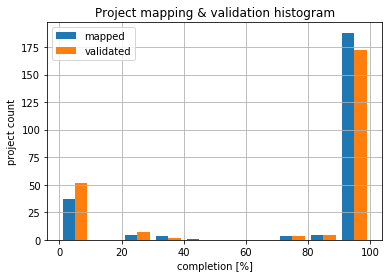

In [6]:
# Stats summary of all discovered projects


def summarize_projects(df):
    """df: pandas dataframe of TM projects"""
    
    # number of projects completely mapped & validated
    completed = len(df[(df.percentMapped >= 99) & (df.percentValidated >= 99)])

    display(Markdown(
    f'''
- Total number projects: {len(df)}
    - Drafts:    {len(df[df.status=='DRAFT'])}
    - Published: {len(df[df.status=='PUBLISHED'])} 
    - Archived:  {len(df[df.status=='ARCHIVED'])}
- Completed projects (100% mapped & validated): {completed}
- Average % mapped across all projects: {df.percentMapped.mean():.1f} %
- Average % validated across all projects: {df.percentValidated.mean():.1f} %
'''))

summarize_projects(result)


activation_length = datetime.now() - ACTIVATION_DATE
completed = len(result[(result.percentMapped >= 99) & (result.percentValidated >= 99)])

# average project completion rate during activation
completion_rate = completed / activation_length.days

display(Markdown(f'- Average completion rate: {completion_rate:.2f} projects/day'))


plt.figure()
plt.hist(
    [result['percentMapped'],result['percentValidated']],
    label=['mapped', 'validated'],
    bins=range(0,101,10))
plt.title('Project mapping & validation histogram')
plt.xlabel('completion [%]')
plt.ylabel('project count')
plt.legend();plt.grid()
plt.show()

## Projects Pending Acrchival


The projects listed below have high (> 99 %) completion of both mapping and validation, and are in _Published_ status in Tasking Manager.
These are ready for a 2nd validation pass and eventually archiving

In [7]:

def pending_archival(df):
    """list complete but still published TM projects"""
    pending_archival = df[
        (df.percentMapped >= 99) & \
        (df.percentValidated >= 99) & \
        (df.status == 'PUBLISHED')
    ]
    display(Markdown('Pending projects:'))
    display(Markdown(str(list(pending_archival['projectId']))))
    
pending_archival(result)

Pending projects:

[8416, 8545, 8771, 8812, 8823, 8925, 8926, 8963, 8964, 8986, 8988, 8989, 8992, 8997, 9191, 9358]

# Complete Project Listing

In [10]:

# Apply table styling and automatic colors
styled = display_result.style\
    .background_gradient(
        cmap=hotosm_cmap(),
        subset=['percentMapped', 'percentValidated']
    )\
    .applymap(format_priority, subset=['priority'])\
    .applymap(format_status, subset=['status'])

display(styled)


,projectId,name,country,percentMapped,percentValidated,mapperLevel,status,priority
2,9178,COVID-19 - Anguilla Update,Anguilla,99,74,INTERMEDIATE,PUBLISHED,URGENT
226,9473,"COVID-19 Saint Peter, Barbados",Barbados,0,0,BEGINNER,DRAFT,LOW
227,9474,"COVID-19 Saint Thomas, Barbados",Barbados,0,0,BEGINNER,DRAFT,LOW
228,9475,"COVID-19 Saint Andrew, Barbados",Barbados,0,0,BEGINNER,DRAFT,LOW
229,9477,"COVID-19 Saint George, Barbados",Barbados,0,0,BEGINNER,DRAFT,LOW
230,9478,"COVID-19 Saint Joseph, Barbados",Barbados,0,0,BEGINNER,DRAFT,LOW
231,9479,"COVID-19 Saint Lucy, Barbados",Barbados,0,0,BEGINNER,DRAFT,LOW
232,9480,"COVID-19 Saint Philip, Barbados",Barbados,0,0,INTERMEDIATE,DRAFT,LOW
233,9481,"COVID-19 Christ Church, Barbados",Barbados,0,0,INTERMEDIATE,DRAFT,LOW
234,9482,"COVID-19 Saint James, Barbados",Barbados,0,0,INTERMEDIATE,DRAFT,LOW


# Access the data as a spreadsheet

Besides displaying the data inline in this notebook, it is also exported as an excel file to the workspace. See the file "HOTOSM-covid-19-automatic.xlsx" in the colab sidebard. You may need to click the "Referesh" icon in the file tree to see the exported spreadsheet.

